# Characterizing Observational Database Research Using Python:<br> CPRD - Clinical Practice Research Datalink
Fall 2020 Associate Fellowship Project<br>
Amanda Sawyer, MLIS<br>
Project Sponsor: Vojtech Huser, MD, PhD

In [2]:
from Bio import Entrez
from Bio import Medline
import numpy as np
import pandas as pd
from csv import reader
import re
from ratelimiter import RateLimiter
import pubmed_parser as pp
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from matplotlib import cm

In [3]:
Entrez.email = "amanda.sawyer@nih.gov"
api_key = '86d72be66a4381e2e22c704615cbb9620c08'

**1. Collecting Article Metadata with NCBI E-Utilities and Biopython**

In [4]:
#Create a DataFrame from the CSV file 
fileName = 'dfs2.csv'
cprd_df = pd.read_csv(fileName, usecols = ['TITLE', 'YEAR', 'ISSN', 'DOI'], encoding='ANSI')

In [5]:
#Defining a function to search PubMed for article title and returns PMID if title is found.
#Limit to 10 requests per second per NCBI guidelines

@RateLimiter(max_calls=10, period=1)
def getPMID(articleTitle) :
    handle = Entrez.esearch(db="pubmed", retmax=1, term=articleTitle)
    record = Entrez.read(handle)
    handle.close()
    pmid = record['IdList']
    return pmid

In [6]:
#Apply the getPMID function to DataFrame to retreive PMIDs for articles in CSV that are listed in PubMed
#Convert PMID list to string in column
cprd_df['PMID'] = cprd_df['TITLE'].apply(getPMID)
cprd_df['PMID'] = cprd_df['PMID'].str[0]
cprd_df.head()

TITLE  YEAR  \
0  Ability of primary care health databases to as...  2020   
1  Accelerated FEV(1) decline and risk of cardiov...  2020   
2  Adaptive Treatment Strategies with Survival Ou...  2020   
3  Adequacy of Therapy for People with Both COPD ...  2020   
4  Adverse pregnancy outcomes and subsequent deve...  2020   

                          ISSN                          DOI      PMID  
0                    0009-9236             10.1002/cpt.1775  31955404  
1                    0903-1936  10.1183/13993003.00918-2020       NaN  
2                    0002-9262           10.1093/aje/kwz272  31903490  
3  1179-7266 (Print) 1179-7266          10.2147/por.s250451  32581622  
4                    1470-0328      10.1111/1471-0528.16191  32128978

In [7]:
#Check for null values to determine what articles are not in PubMed.
check_nan = cprd_df['PMID'].isnull().sum()
check_nan

208

In [8]:
#Create new dataframe that only includes publications with PMIDs, reset the index in order to find new number of publications
#208 publications removed
cprd_df = cprd_df[cprd_df['PMID'].notna()]
cprd_df = cprd_df.reset_index()
cprd_df.head()

index                                              TITLE  YEAR  \
0      0  Ability of primary care health databases to as...  2020   
1      2  Adaptive Treatment Strategies with Survival Ou...  2020   
2      3  Adequacy of Therapy for People with Both COPD ...  2020   
3      4  Adverse pregnancy outcomes and subsequent deve...  2020   
4      6  Antibiotic prescribing for lower UTI in elderl...  2020   

                          ISSN                           DOI      PMID  
0                    0009-9236              10.1002/cpt.1775  31955404  
1                    0002-9262            10.1093/aje/kwz272  31903490  
2  1179-7266 (Print) 1179-7266           10.2147/por.s250451  32581622  
3                    1470-0328       10.1111/1471-0528.16191  32128978  
4  1549-1277 (Print) 1549-1277  10.1371/journal.pmed.1003336  32956399

In [ ]:
#Save results to desktop in a CSV
cprd_df.to_csv(r'Enter Path', index = False)

In [9]:
#Defining a function to return PubMed metadata (MeSH) for PMIDs in DataFrame
#Limit to 10 requests per second per NCBI guidelines

@RateLimiter(max_calls=10, period=1)
def getMeshHeadings (pmid) :
    mesh = []
     
    handle = Entrez.efetch(db='pubmed', id=pmid, rettype='medline', retmode='text')
    records = Medline.parse(handle)
    
    for record in records:
        try :
            mesh = record['MH']
        except : pass
        
    return mesh

In [10]:
#Apply the getPMID function to DataFrame to retreive PMIDs for articles in CSV that are listed in PubMed
cprd_df['MeSH'] = cprd_df['PMID'].apply(getMeshHeadings)

In [11]:
#Explode on keywords, so that each term has it's own row.
#Reindex the DataFrame
cprd_df = cprd_df.explode('MeSH')

In [15]:
cprd_df = cprd_df.reset_index()
cprd_df = cprd_df.rename(columns={"index": "Article ID"})

In [16]:
cprd_df.head()

Article ID                                              TITLE  YEAR  \
0           0  Ability of primary care health databases to as...  2020   
1           1  Ability of primary care health databases to as...  2020   
2           2  Ability of primary care health databases to as...  2020   
3           3  Ability of primary care health databases to as...  2020   
4           4  Ability of primary care health databases to as...  2020   

        ISSN               DOI      PMID  \
0  0009-9236  10.1002/cpt.1775  31955404   
1  0009-9236  10.1002/cpt.1775  31955404   
2  0009-9236  10.1002/cpt.1775  31955404   
3  0009-9236  10.1002/cpt.1775  31955404   
4  0009-9236  10.1002/cpt.1775  31955404   

                                                MeSH  
0     Databases, Factual/statistics & numerical data  
1  Electronic Health Records/*legislation & juris...  
2        *European Union/statistics & numerical data  
3                                             Humans  
4     *Legislation, Drug/statistics & numerical data

In [17]:
#Split the descriptors from the qualifers into spearate columns in the DataFrame
descriptor = []
qualifier = []
   
for x, y in cprd_df['MeSH'].iteritems():
    if pd.notnull(y):
        head, sep, tail = y.partition('/')
        descriptor.append(head)
        qualifier.append(tail)
    else:
        descriptor.append('')
        qualifier.append('')

cprd_df['Descriptor'] = descriptor
cprd_df['Qualifier'] = qualifier

In [ ]:
cprd_df.to_csv(r'Enter Path', index=False)

**Data Cleaning for Comparison**

In [18]:
#Drop records from DataFrame where there are 0 MeSH terms - these are outside of the scope of this project.
cprd_df = cprd_df.dropna(subset=['MeSH'])

In [19]:
def remove_punctuation(x):
    x = x.replace('*','')
    return x

def lowercase(x):
    x = x.lower()
    return x

cprd_df['MeSH Cleaned'] = cprd_df['Descriptor'].apply(remove_punctuation)
cprd_df['MeSH Cleaned'] = cprd_df['MeSH Cleaned'].str.lower()

In [20]:
cprd_df.head()

Article ID                                              TITLE  YEAR  \
0           0  Ability of primary care health databases to as...  2020   
1           1  Ability of primary care health databases to as...  2020   
2           2  Ability of primary care health databases to as...  2020   
3           3  Ability of primary care health databases to as...  2020   
4           4  Ability of primary care health databases to as...  2020   

        ISSN               DOI      PMID  \
0  0009-9236  10.1002/cpt.1775  31955404   
1  0009-9236  10.1002/cpt.1775  31955404   
2  0009-9236  10.1002/cpt.1775  31955404   
3  0009-9236  10.1002/cpt.1775  31955404   
4  0009-9236  10.1002/cpt.1775  31955404   

                                                MeSH  \
0     Databases, Factual/statistics & numerical data   
1  Electronic Health Records/*legislation & juris...   
2        *European Union/statistics & numerical data   
3                                             Humans   
4     *Legislation, Drug/statistics & numerical data   

                  Descriptor  \
0         Databases, Factual   
1  Electronic Health Records   
2            *European Union   
3                     Humans   
4         *Legislation, Drug   

                                           Qualifier  \
0                        statistics & numerical data   
1  *legislation & jurisprudence/statistics & nume...   
2                        statistics & numerical data   
3                                                      
4                        statistics & numerical data   

                MeSH Cleaned  
0         databases, factual  
1  electronic health records  
2             european union  
3                     humans  
4          legislation, drug

**Create Diseases DataFrame from MeSH Data**

In [21]:
diseasesFN = 'mesh-ctree-diseases.xlsx'
diseases = pd.read_excel(diseasesFN)

def splitTerms(term) :
    return re.findall("\[([^[\]]*)\]", term)

def deleteExtraInfo(term):
    x = term.split(" [", 1)
    return x[0]

diseases['Full Term'] = diseases['Term']
diseases['Code'] = diseases['Term'].apply(splitTerms)
diseases['Term'] = diseases['Term'].apply(deleteExtraInfo)
diseases['Term'] = diseases['Term'].str.lower()

In [22]:
diseases.head()

Term                          Full Term           Code
0               infections                  Infections [C01]           [C01]
1       aneurysm, infected       Aneurysm, Infected [C01.069]      [C01.069]
2    arthritis, infectious   Arthritis, Infectious [C01.100]       [C01.100]
3      arthritis, reactive  Arthritis, Reactive [C01.100.500]  [C01.100.500]
4  asymptomatic infections  Asymptomatic Infections [C01.125]      [C01.125]

**Calcuate MeSH Frequency**

In [23]:
frequency_cprd = pd.DataFrame(cprd_df['MeSH Cleaned'].value_counts())
frequency_cprd = frequency_cprd.reset_index()
frequency_cprd = frequency_cprd.rename(columns={"index": "Term"})

In [24]:
diseaseFrequency_cprd = frequency_cprd.where(frequency_cprd['Term'].isin(diseases['Term']))
diseaseFrequency_cprd = diseaseFrequency_cprd.dropna()
total = diseaseFrequency_cprd['MeSH Cleaned'].sum()
diseaseFrequency_cprd['Percentage'] = (diseaseFrequency_cprd['MeSH Cleaned'] / total) * 100
diseaseFrequency_cprd[:20]

Term  MeSH Cleaned  Percentage
18                diabetes mellitus, type 2         212.0    5.771849
32                  cardiovascular diseases         133.0    3.621018
44                    myocardial infarction          87.0    2.368636
47                                   stroke          80.0    2.178056
52                                neoplasms          68.0    1.851348
55   pulmonary disease, chronic obstructive          67.0    1.824122
56                                   asthma          66.0    1.796896
60                             hypertension          64.0    1.742445
72                      disease progression          50.0    1.361285
74                         breast neoplasms          49.0    1.334059
75                            heart failure          49.0    1.334059
78                          fractures, bone          46.0    1.252382
85                      atrial fibrillation          41.0    1.116254
86                                  obesity          40.0    1.089028
88                   venous thromboembolism          40.0    1.089028
95                        diabetes mellitus          38.0    1.034577
96                         influenza, human          38.0    1.034577
97                    arthritis, rheumatoid          37.0    1.007351
106                            osteoporosis          34.0    0.925674
107            respiratory tract infections          34.0    0.925674

**Visualize Frequency Table**

In [25]:
sizes = diseaseFrequency_cprd['Percentage']
names = diseaseFrequency_cprd['Term']

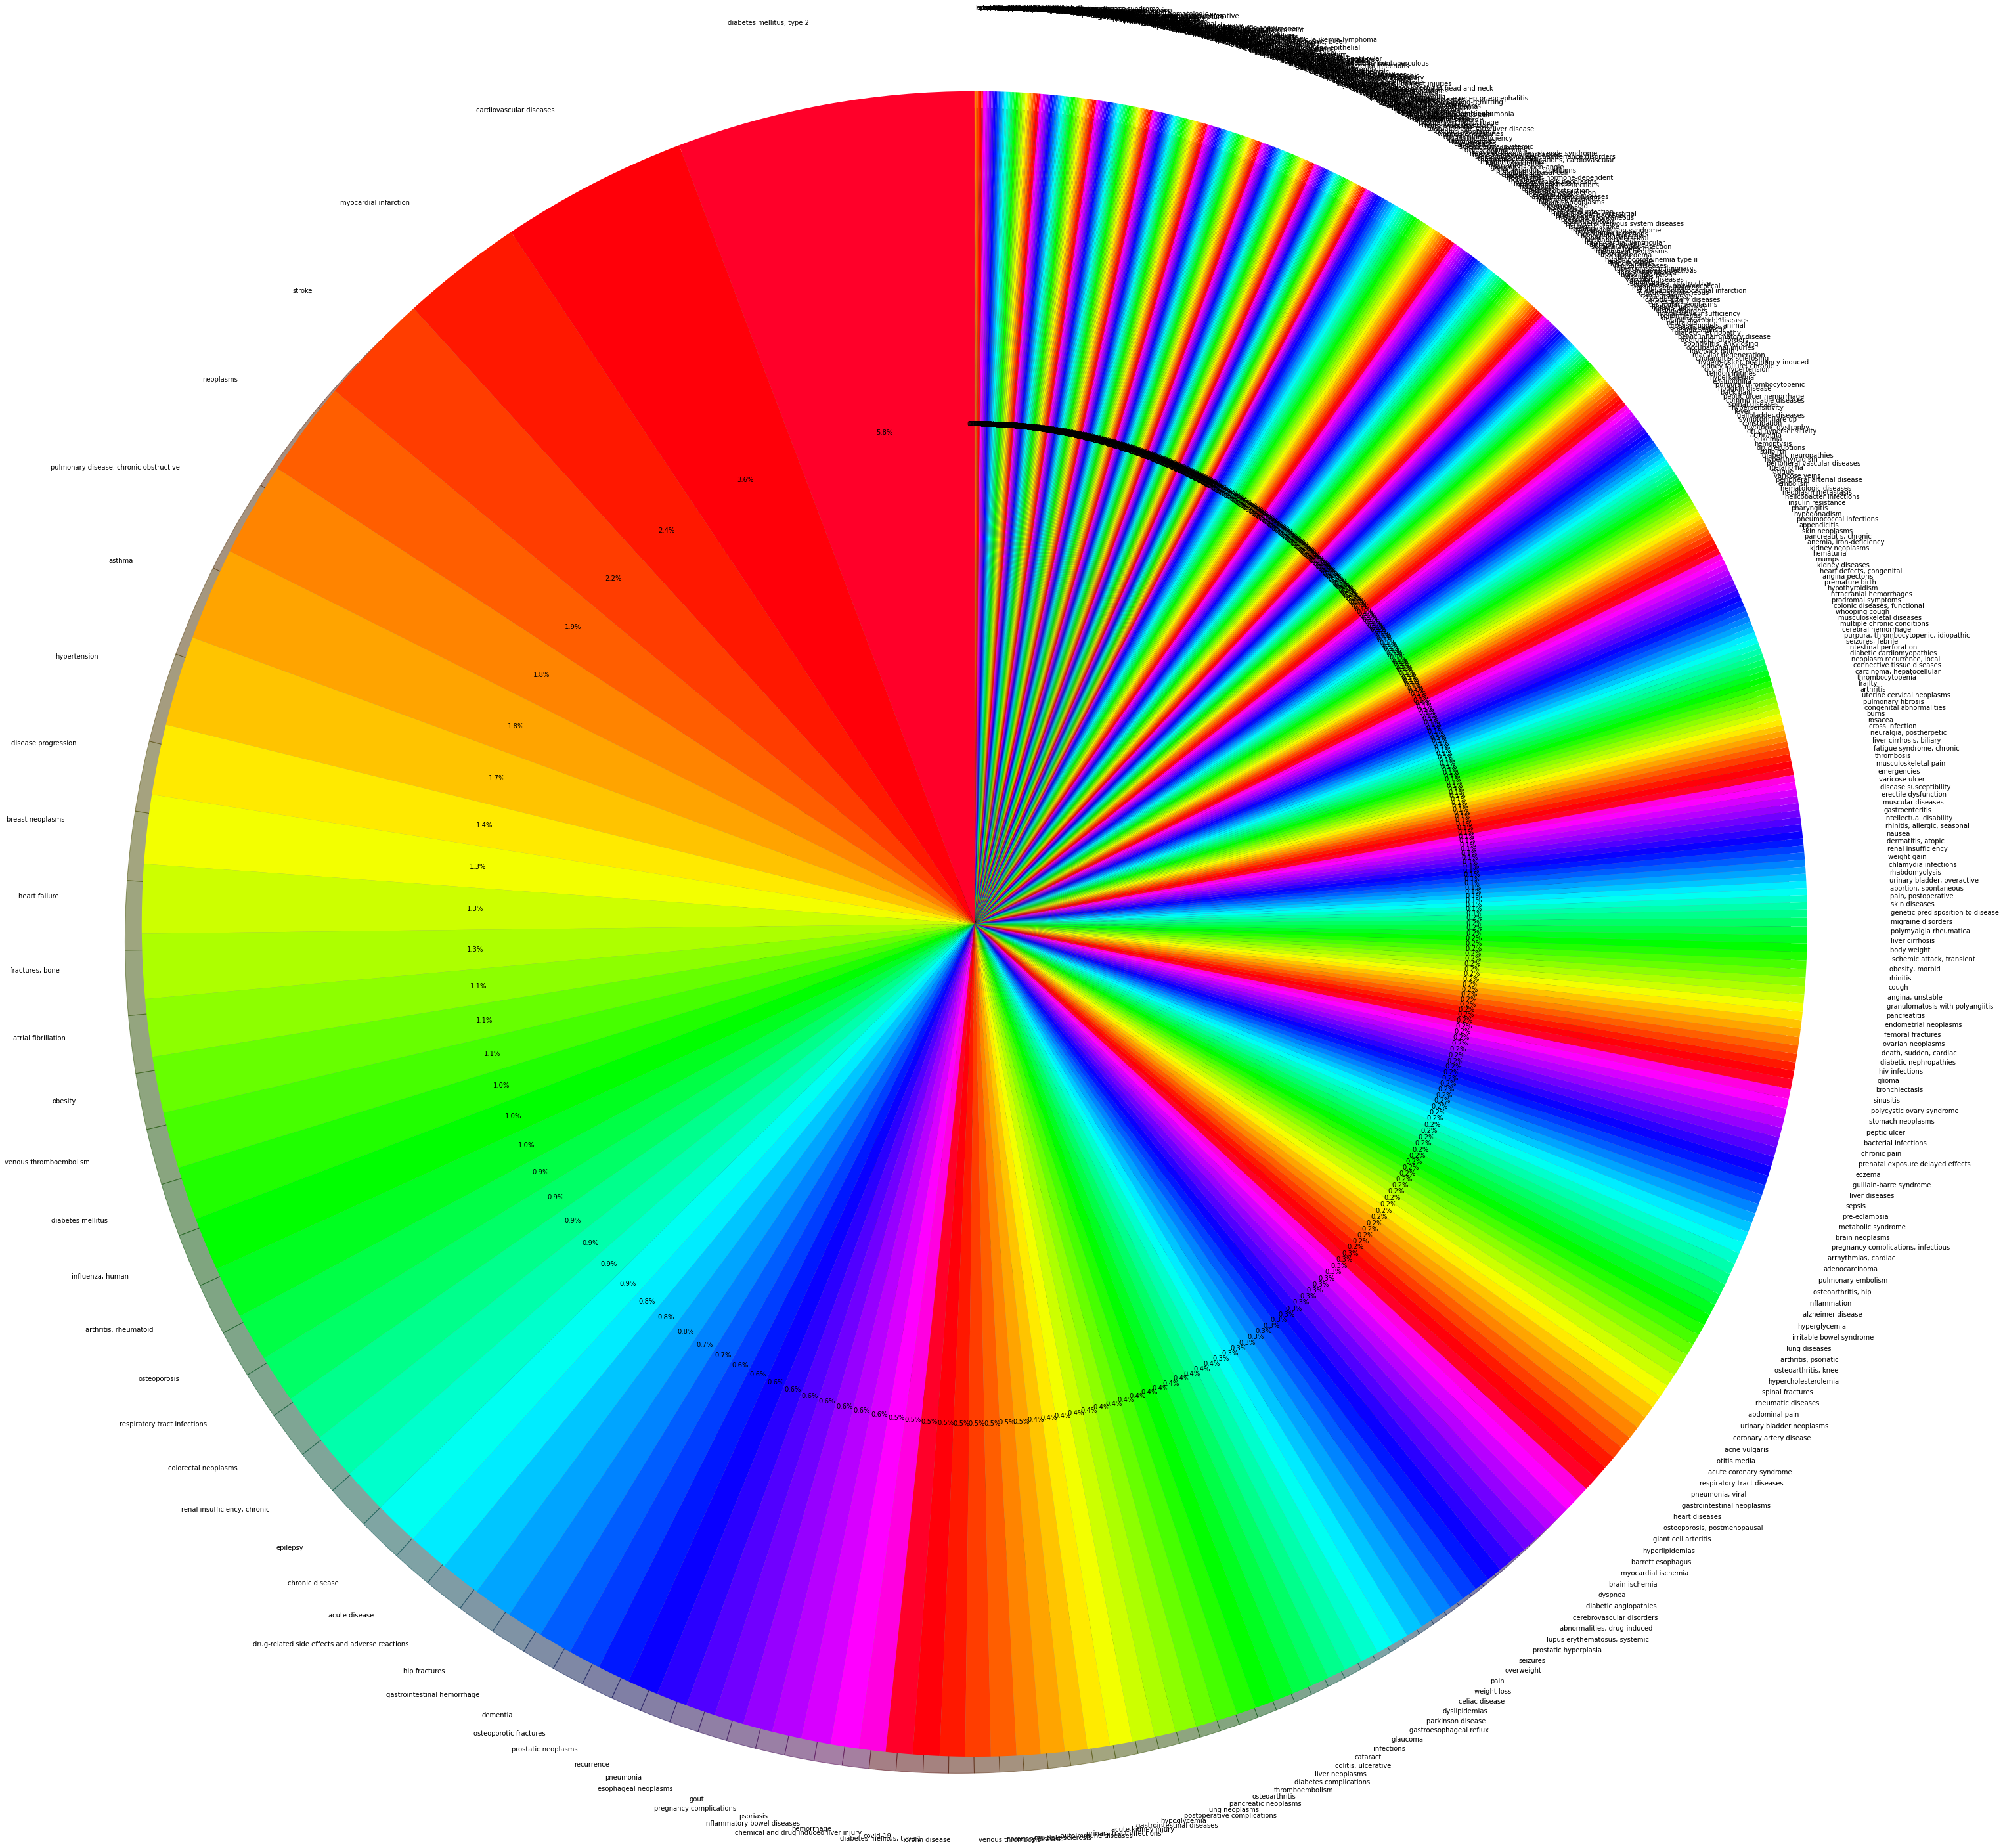

In [28]:
#Create a pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = names
sizes = sizes

cs=cm.gist_rainbow(np.arange(40)/40.)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=cs, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
fig = plt.gcf()
fig.set_size_inches(50,50)
plt.show()